# Grundlagen – Teil 1: Dispersion der Prisma

Beim Durchgang eines Lichtstrahls durch ein Prisma wird der Strahl an beiden Grenzflächen gebrochen.
Das Verhalten des Lichts wird durch das Brechungsgesetz von Snellius beschrieben:
$$n_1 \sin(\alpha) = n_2 \sin(\beta)$$

Hierbei gilt:
- $n_1, n_2$ - Brechungsindizes der beteiligten Medien (Luft → Glas → Luft)
- $\alpha$ - Einfallswinckel
- $\beta$ - Brechungswinkel

---

Für eine gleichseitige Prisma mit Scheitelwinkel  $\varepsilon$ (z.B. 60°) ergibt sich für die gesamte Ablenkung $\delta$ des Strahls:
$$\delta = \alpha_1 + \alpha_2 = \epsilon$$

Im allgemeinen Fall ist der Strahlengang asymmetrisch, d. h. die Einfalls- und Austrittswinkel unterscheiden sich.
Bei der minimalen Ablenkung $\delta_{min}$ verläuft der Strahl jedoch __symmetrisch__:

$$\alpha_1 = \alpha_2 \text{ und } \beta_1 = \beta_2 ={\varepsilon\over{2}}$$

Unter dieser Bedingung lässt sich der __Brechungsindex des Prismamaterials__ berechnen zu:
$$n = {\sin ({{\delta_{min} + \varepsilon} \over {2}}) \over \sin ({{\varepsilon} \over {2}})}$$
---
Da der Brechungsindex von der Wellenlänge $\lambda$ abhängt, spricht man von __Dispersion__.
Für normale Dispersion gilt:
$$n(\lambda_{blau}) > n(\lambda_{rot})$$
also nimmt $n$ mit zunehmender Wellenlänge ab.

Zur quantitativen Beschreibung wird häufig das __Cauchy-Gesetz__ verwendet:
$$n(\lambda)= \text{A} + {{\text{B}} \over {\lambda^2}} + {{\text{C}} \over {\lambda^4}}$$



# Grundlagen – Teil 2: Absorptionsspektroskopie

Beim Durchgang von Licht durch eine absorbierende Substanz wird ein Teil der einfallenden Strahlung geschwächt.  
Die Intensität des Lichtes nimmt dabei exponentiell mit der durchlaufenen Schichtdicke ab.  
Dieses Verhalten wird durch das **Lambert-Beer’sche Gesetz** beschrieben:

$$
I(d,\lambda) = I_0(\lambda) \, e^{-\alpha(\lambda) \, d}
$$

Hierbei gilt:  
- $I_0(\lambda)$ – einfallende Intensität (ohne Probe)  
- $I(d,\lambda)$ – Intensität nach Durchgang durch die Probe  
- $\alpha(\lambda)$ – Absorptionskoeffizient  
- $d$  – Schichtdicke der absorbierenden Substanz  

---

Zur experimentellen Bestimmung wird meist der **Transmissionsgrad** \( T \) verwendet:

$$
T(\lambda) = \frac{I(d,\lambda)}{I_0(\lambda)} = e^{-\alpha(\lambda) \, d}
$$

Aus dem Transmissionsgrad lässt sich die sogenannte **Optische Dichte (OD)** berechnen:

$$
\mathrm{OD}(\lambda) = - \log_{10} \, T(\lambda) = \log_{10} \!\left(\frac{I_0(\lambda)}{I(d,\lambda)}\right)
$$

Eine hohe optische Dichte bedeutet starke Absorption,  
während eine kleine OD auf hohe Transmission hinweist.

---

Bestimmte Stoffe absorbieren Licht nur bei charakteristischen Wellenlängen.  
Diese **Absorptionsbanden** sind eine Folge von elektronischen Übergängen in den Atomen oder Ionen.  
Für wässrige Lösungen seltener Erdionen wie **Neodym (Nd³⁺)** und **Praseodym (Pr³⁺)**  
liegen diese Banden im sichtbaren Bereich und sind daher leicht spektroskopisch messbar.

---

Die typischen Absorptionslinien sind (nach der Versuchsanleitung):

| Ion | Charakteristische Absorptionslinien (in nm) |
|-----|---------------------------------------------|
| Nd³⁺ | 510, 522, 578, 740, 799, 868 |
| Pr³⁺ | 444, 468, 481, 590 |

---

Zur Auswertung wird aus den gemessenen Intensitäten \( I_0(\lambda) \) und \( I(\lambda) \)  
die Funktion \( \mathrm{OD}(\lambda) \) berechnet und grafisch dargestellt.  
Die Lage der Maxima in diesem **Absorptionsspektrum** erlaubt die eindeutige Identifikation des Ions in der Probe.  

So zeigt ein Spektrum mit starken Maxima bei etwa 520 nm und 580 nm auf die Anwesenheit von **Neodym**,  
während Linien bei etwa 445 nm und 590 nm auf **Praseodym** hinweisen.


[Prisma] Cauchy-Parameter: A=1.124509, B=27539.1, C=-2.077e+09

[Absorption] Entscheidung: Neodym
[Absorption] Nd-Treffer (Ref, Peak, Δnm):
  522.0 → 521.80 (Δ=-0.20)
  578.0 → 578.30 (Δ=+0.30)


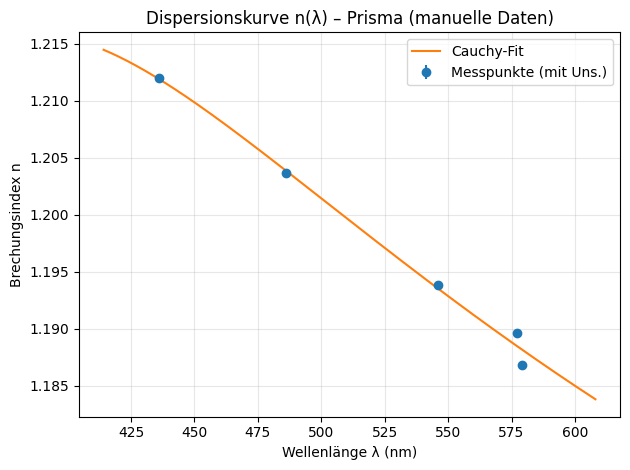

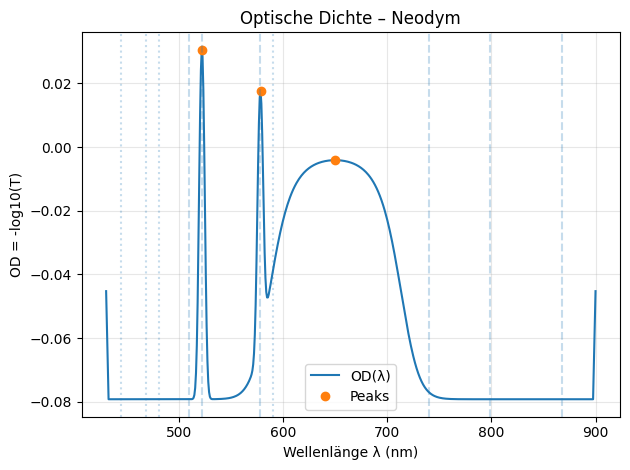

In [4]:
"""
PW3 – Manuelle Dateneingabe (Arrays/Listen)
===========================================
Dieses Skript analysiert:
1) Dispersionskurve einer Prismamessung aus manuell eingegebenen Arrays
2) Absorptionsspektroskopie (OD) aus manuell eingegebenen Arrays
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# ---------------------------------------------------------
# DATENEINGABE
# ---------------------------------------------------------

# --- (1) PRISMA

# Wellenlängen der Kalibrationslinien (nm):
wavelength_nm = np.array([436.0, 486.1, 546.1, 577.0, 579.1], dtype=float)

# Ablesewinkel (Grad) – Richtung ohne Prisma:
phi1_deg = np.array([12.4, 12.6, 12.9, 13.0, 13.1], dtype=float)

# Ablesewinkel (Grad) – Richtung in minimaler Ablenkung:
phi2_deg = np.array([27.0, 26.6, 26.2, 26.0, 25.9], dtype=float)

# Brechender Winkel des Prismas ε (Grad) – gleicher Wert für alle Punkte:
epsilon_deg = 60.0

# (Optional) Ableseunsicherheit pro Winkel (Winkelminute) – gleicher Wert für alle Punkte:
phi_unc_arcmin = 1.0  # z.B. 1'

# --- (2) ABSORPTION: Referenz- und Probenspektrum (gleiches λ-Raster empfohlen) ---
# Gemeinsame Wellenlängenachse (nm):
lam_abs = np.linspace(430, 900, 600)  # ersetzen durch Ihre Messachse

# Referenzintensität (ohne Probe):
I_ref = np.exp(-0.0008*(lam_abs-650)**2) * 1.0 + 0.05  

# Intensität mit Probe:
I_sam = I_ref.copy()
# Beispielhafte Absorptionsbanden (fügen Sie Ihre Daten ein, nicht diese Modellierung):
I_sam *= (1 - 0.35*np.exp(-0.5*((lam_abs-522)/2.0)**2))
I_sam *= (1 - 0.25*np.exp(-0.5*((lam_abs-578)/2.0)**2))
I_sam += 0.01

# ---------------------------------------------------------
# HILFSFUNKTIONEN (Formeln gemäß Praktikumsbeschreibung)
# ---------------------------------------------------------

def deg2rad(x):
    """Grad → Radiant."""
    return np.deg2rad(x)

def arcmin2deg(x_arcmin):
    """Winkelminute → Grad."""
    return x_arcmin / 60.0

def calc_delta_min(phi1, phi2):
    """Minimale Ablenkung δ_min = |phi2 - phi1| (in Grad)."""
    return np.abs(phi2 - phi1)

def n_from_prism(delta_min_deg, epsilon_deg):
    """
    Brechungsindex: n = sin((δ_min + ε)/2) / sin(ε/2), Winkel in Grad.
    """
    num = np.sin(deg2rad((delta_min_deg + epsilon_deg)/2.0))
    den = np.sin(deg2rad(epsilon_deg/2.0))
    return num/den

def sigma_n_from_delta(delta_min_deg, epsilon_deg, sigma_delta_deg):
    """
    Fehlerfortpflanzung nur über δ_min (ε als exakt angenommen):
    dn/dδ = (1/2)*cos((δ+ε)/2)/sin(ε/2)  (Argumente in Radiant)
    """
    eps2 = deg2rad(epsilon_deg/2.0)
    x = deg2rad((delta_min_deg + epsilon_deg)/2.0)
    dnddelta = 0.5*np.cos(x)/np.sin(eps2)
    return np.abs(dnddelta) * deg2rad(sigma_delta_deg)

def cauchy(lambda_nm, A, B, C=0.0):
    """Cauchy-Dispersion: n(λ) = A + B/λ² + C/λ⁴ (λ in nm)."""
    lam = np.array(lambda_nm, float)
    return A + B/lam**2 + C/lam**4

def fit_cauchy(lambda_nm, n_vals, use_C=True):
    """Nichtlinearer Fit der Cauchy-Gleichung."""
    lam = np.array(lambda_nm, float)
    nv = np.array(n_vals, float)
    if use_C:
        p0 = [np.median(nv), 1e4, 1e9]
        popt, pcov = curve_fit(cauchy, lam, nv, p0=p0, maxfev=10000)
    else:
        def cauchy2(x, A, B): return A + B/x**2
        p0 = [np.median(nv), 1e4]
        popt2, pcov2 = curve_fit(cauchy2, lam, nv, p0=p0, maxfev=10000)
        popt = [popt2[0], popt2[1], 0.0]
        pcov = np.zeros((3,3)); pcov[:2,:2] = pcov2
    return popt, pcov

def compute_OD(lam, Iref, Isam, smooth_pts=None):
    """
    Optische Dichte: T = Isam/Iref, OD = -log10(T).
    'lam' muss zu Iref/Isam passen (gleiche Länge).
    Optional Glättung über gleitendes Mittel (smooth_pts).
    """
    lam = np.array(lam, float)
    Iref = np.array(Iref, float)
    Isam = np.array(Isam, float)

    T = np.clip(Isam/np.maximum(Iref, 1e-12), 1e-12, None)
    OD = -np.log10(T)

    if smooth_pts and smooth_pts > 1:
        k = int(smooth_pts)
        ker = np.ones(k)/k
        OD = np.convolve(OD, ker, mode="same")
    return lam, OD

# Referenzlinien (nm) für grobe Identifikation (Nd/Pr):
ND_LINES = np.array([510, 522, 578, 740, 799, 868], float)
PR_LINES = np.array([444, 468, 481, 590], float)

def find_od_peaks(lam, OD, prominence=0.03, distance_nm=1.0):
    """
    Peaks in OD(λ) (AbsorptionsMAXIMA) finden.
    prominence: relative Prominenz auf normalisierter OD.
    distance_nm: Mindestabstand der Peaks in nm.
    """
    lam = np.array(lam, float)
    OD = np.array(OD, float)
    ODn = (OD - np.nanmin(OD)) / (np.nanmax(OD) - np.nanmin(OD) + 1e-12)
    dl = np.median(np.diff(lam))
    dist_pts = max(1, int(distance_nm/max(dl,1e-9)))
    idx, props = find_peaks(ODn, prominence=prominence, distance=dist_pts)
    return lam[idx], OD[idx], props

def match_lines(peaks_nm, ref_lines, tol_nm=2.0):
    """Ordnet Peaks Referenzlinien zu, falls |Δλ| ≤ tol_nm."""
    results = []
    for r in ref_lines:
        i = np.argmin(np.abs(peaks_nm - r))
        if np.abs(peaks_nm[i] - r) <= tol_nm:
            results.append((r, peaks_nm[i], peaks_nm[i]-r))
    return results

# ---------------------------------------------------------
# (1) PRISMA – AUSWERTUNG
# ---------------------------------------------------------

# Konsistenzprüfungen
assert len(wavelength_nm)==len(phi1_deg)==len(phi2_deg), "Alle Prismalisten müssen gleich lang sein."

delta_min_deg = calc_delta_min(phi1_deg, phi2_deg)
n_vals = n_from_prism(delta_min_deg, epsilon_deg)

# Unsicherheit (wenn gewünscht): σ_δ = sqrt(σ_phi1^2 + σ_phi2^2), hier beide gleich angenommen
sigma_phi_deg = arcmin2deg(phi_unc_arcmin)
sigma_delta_deg = np.sqrt(2) * sigma_phi_deg
n_unc = sigma_n_from_delta(delta_min_deg, epsilon_deg, sigma_delta_deg)

# Cauchy-Fit (mit C-Term; bei sehr wenigen Punkten ggf. use_C=False wählen)
popt, pcov = fit_cauchy(wavelength_nm, n_vals, use_C=True)
A,B,C = popt

print("[Prisma] Cauchy-Parameter:", f"A={A:.6f}, B={B:.1f}, C={C:.3e}")

# Plot Dispersionskurve
plt.figure()
if np.isfinite(n_unc).any():
    plt.errorbar(wavelength_nm, n_vals, yerr=n_unc, fmt="o", label="Messpunkte (mit Uns.)")
else:
    plt.plot(wavelength_nm, n_vals, "o", label="Messpunkte")

lam_fit = np.linspace(min(wavelength_nm)*0.95, max(wavelength_nm)*1.05, 400)
plt.plot(lam_fit, cauchy(lam_fit, *popt), "-", label=f"Cauchy-Fit")
plt.xlabel("Wellenlänge λ (nm)")
plt.ylabel("Brechungsindex n")
plt.title("Dispersionskurve n(λ) – Prisma (manuelle Daten)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# ---------------------------------------------------------
# (2) ABSORPTION – AUSWERTUNG
# ---------------------------------------------------------

# OD berechnen
lam_od, OD = compute_OD(lam_abs, I_ref, I_sam, smooth_pts=7)

# Peaks in OD finden
peaks_nm, peaks_OD, props = find_od_peaks(lam_od, OD, prominence=0.03, distance_nm=1.5)

# Zuordnung zu Nd/Pr
nd_matches = match_lines(peaks_nm, ND_LINES, tol_nm=2.0)
pr_matches = match_lines(peaks_nm, PR_LINES, tol_nm=2.0)

if nd_matches and not pr_matches:
    decision = "Neodym"
elif pr_matches and not nd_matches:
    decision = "Praseodym"
elif nd_matches and pr_matches:
    decision = "Mischung (Nd+Pr)"
else:
    decision = "unklar"

print("\n[Absorption] Entscheidung:", decision)
if nd_matches:
    print("[Absorption] Nd-Treffer (Ref, Peak, Δnm):")
    for r,p,d in nd_matches: print(f"  {r:.1f} → {p:.2f} (Δ={d:+.2f})")
if pr_matches:
    print("[Absorption] Pr-Treffer (Ref, Peak, Δnm):")
    for r,p,d in pr_matches: print(f"  {r:.1f} → {p:.2f} (Δ={d:+.2f})")

# Plot OD + Peaks + Referenzlinien
plt.figure()
plt.plot(lam_od, OD, label="OD(λ)")
if len(peaks_nm)>0:
    plt.plot(peaks_nm, np.interp(peaks_nm, lam_od, OD), "o", label="Peaks")
for l in ND_LINES: plt.axvline(l, linestyle="--", alpha=0.25)  # Nd
for l in PR_LINES: plt.axvline(l, linestyle=":",  alpha=0.25)  # Pr
plt.xlabel("Wellenlänge λ (nm)")
plt.ylabel("OD = -log10(T)")
plt.title(f"Optische Dichte – {decision}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()
